In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
# Configuración warnings
# ==============================================================================
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

In [4]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')
datos.head()

,x,fecha
0,0.429795,1991-07-01
1,0.400906,1991-08-01
2,0.432159,1991-09-01
3,0.492543,1991-10-01
4,0.502369,1991-11-01


In [5]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()
datos.head()

fecha
1991-07-01    0.429795
1991-08-01    0.400906
1991-09-01    0.432159
1991-10-01    0.492543
1991-11-01    0.502369
Freq: MS, Name: y, dtype: float64

In [52]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start = datos.index.min(),
                              end   = datos.index.max(),
                              freq  = datos.index.freq)).all()

True

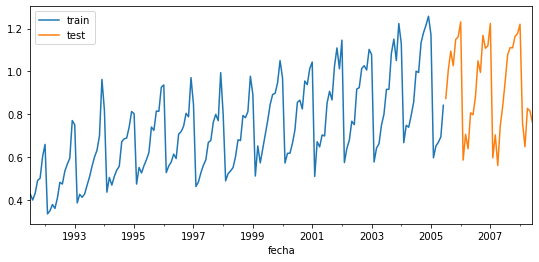

In [54]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train =   
datos_test  = datos[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

In [55]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=123),
                    lags=6
                )

forecaster_rf.fit(y=datos_train)

forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=123)
Lags: [1 2 3 4 5 6]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

In [56]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)
predicciones.head()

fecha
2005-07-01    0.866263
2005-08-01    0.874688
2005-09-01    0.951697
2005-10-01    0.991223
2005-11-01    0.952589
Freq: MS, dtype: float64

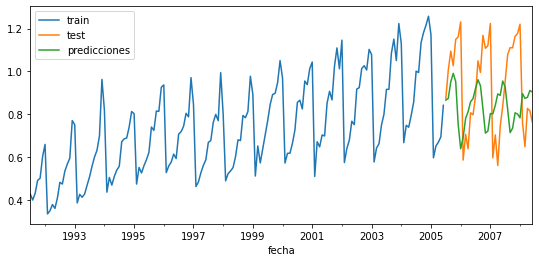

In [57]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [58]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.0665147739321922


In [59]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [10, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False)

2021-11-29 18:23:38,958 root       INFO  Number of models compared: 12
loop lags_grid: 100%|██████████| 2/2 [01:31<00:00, 45.50s/it]
2021-11-29 18:25:09,987 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
params: {'max_depth': 10, 'n_estimators': 500}



In [60]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.005271,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.005331,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.005354,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.005514,5,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.005744,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.005821,3,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.026603,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.028092,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.028693,5,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.028870,5,500


In [61]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 20
                )

forecaster_rf.fit(y=datos_train)

In [62]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

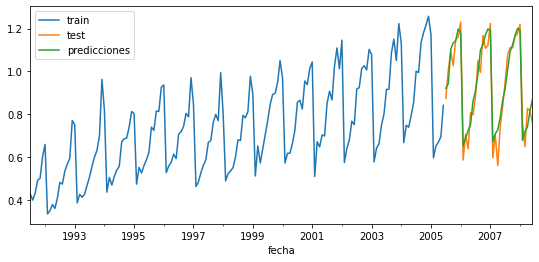

In [63]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [64]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.003977043111878048
